In [29]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from dataclasses import dataclass
import re
import base64
from typing import Optional
import openai
import pickle

    
load_dotenv()
openai.api_key = os.environ["OPENAI_API_KEY"]

@dataclass
class Question:
    id: int
    topic: str
    question: str
    answer_a: str
    answer_b: str
    answer_c: str
    answer_d: str
    image_b64: Optional[str] = None
    image_description: Optional[str] = None
    audio: Optional[str] = None

def describe_image_b64(image_bytes_b64):
    response = openai.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Beschreibe präzise, was auf diesem Bild zu sehen ist. Die Beschreibung muss ohne jegliche Interpretierung der Bedeutung erfolgen."},
                    {"type": "image_url", "image_url": {"url": "data:image/png;base64," + image_bytes_b64}}
                ]
            }
        ],
        max_tokens=150
    )
    return response.choices[0].message.content.strip()

def read_elwis(url: str, topic: str) -> list:
    resp = requests.get(url)
    soup = BeautifulSoup(resp.content, "html.parser")
    content = soup.find('div', {'id': 'content'})
    questions = []
    base_url = url

    p_tags = content.find_all('p', recursive=False)
    for p in p_tags:
        m = re.match(r"\s*(\d+)\.\s*(.*)", p.get_text(strip=True))
        if not m:
            continue
        qid = int(m.group(1))
        qtext = m.group(2)

        ol = p.find_next_sibling(lambda tag: tag.name == "ol" and "elwisOL-lowerLiteral" in tag.get("class", []))
        if not ol:
            continue
        li = ol.find_all("li")
        if len(li) < 4:
            continue

        # --- Image extraction and description ---
        img_url = None
        img = p.find('img')
        if img:
            img_url = urljoin(base_url, img['src'])
        else:
            nxt = p.find_next_sibling('p')
            if nxt and 'picture' in nxt.get('class', []):
                img = nxt.find('img')
                if img:
                    img_url = urljoin(base_url, img['src'])

        image_b64 = None
        image_description = None
        if img_url:
            img_data = requests.get(img_url).content
            image_b64 = base64.b64encode(img_data).decode('utf-8')
            try:
                image_description = describe_image_b64(image_b64)
            except Exception as e:
                image_description = f"Error: {e}"

        questions.append(Question(
            id=qid,
            topic=topic,
            question=qtext,
            answer_a=li[0].get_text(strip=True),
            answer_b=li[1].get_text(strip=True),
            answer_c=li[2].get_text(strip=True),
            answer_d=li[3].get_text(strip=True),
            image_b64=image_b64,
            image_description=image_description,
            audio=None
        ))
    return questions

Das Bild zeigt ein quadratisches Symbol mit einem roten Rand. In der Mitte befinden sich zwei horizontale, geschwungene schwarze Linien. Eine rote diagonale Linie verläuft von der oberen linken Ecke zur unteren rechten Ecke des Symbols. Der Hintergrund des Symbols ist weiß. 

 Welche Bedeutung hat folgendes Tafelzeichen?


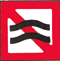

In [17]:
from IPython.display import Image, display
import base64

print(questions[18].image_description, '\n\n', questions[18].question)

image_data = base64.b64decode(questions[18].image_b64)
display(Image(data=image_data))

In [38]:
import json
from dataclasses import asdict, fields

def save_questions(questions, filepath: str):
    questions_dicts = [q.__dict__ for q in questions]

    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(questions_dicts, f, ensure_ascii=False, indent=2)

def load_questions(filepath: str):
    with open(filepath, "r", encoding="utf-8") as f:
        loaded = json.load(f)
    questions = [Question(**q) for q in loaded]
    return questions

save_questions(questions_binnen_segeln, "../questions/questions_binnen_segeln.json")
questions_test = load_questions("../questions/questions_binnen_segeln.json")
questions_test[0]

Question(id=254, topic='Binnen Segeln', question='Was wird unter einem "Kimmkieler" verstanden?', answer_a='Eine Yacht mit zwei Seitenkielen.', answer_b='Eine Yacht mit zwei Seitenschwertern.', answer_c='Eine Yacht mit einem Kielschwert.', answer_d='Eine Yacht mit zwei Kielen hintereinander.', image_b64=None, image_description=None, audio=None)

# Binnen

In [24]:
url = 'https://www.elwis.de/DE/Sportschifffahrt/Sportbootfuehrerscheine/Fragenkatalog-Binnen/Spezifische-Fragen-Segeln/Spezifische-Fragen-Segeln-node.html'
questions_binnen_segeln = read_elwis(url, topic="Binnen Segeln")

In [25]:
url = "https://www.elwis.de/DE/Sportschifffahrt/Sportbootfuehrerscheine/Fragenkatalog-Binnen/Basisfragen/Basisfragen-node.html"
questions_binnen_basis = read_elwis(url, topic="Binnen Basisfragen")

In [33]:
save_questions(questions_binnen_basis, "../questions/questions_binnen_basis.json")

In [26]:
url = "https://www.elwis.de/DE/Sportschifffahrt/Sportbootfuehrerscheine/Fragenkatalog-Binnen/Spezifische-Fragen-Binnen/Spezifische-Fragen-Binnen-node.html"
questions_binnen_spezifisch = read_elwis(url, topic="Binnen Spezifische Fragen")

In [34]:
save_questions(questions_binnen_spezifisch, "../questions/questions_binnen_spezifisch.json")

# See

In [27]:
url = 'https://www.elwis.de/DE/Sportschifffahrt/Sportbootfuehrerscheine/Fragenkatalog-See/Basisfragen/Basisfragen-node.html'
questions_see_basis = read_elwis(url, "See Basisfragen")

In [35]:
save_questions(questions_see_basis, "../questions/questions_see_basis.json")

In [28]:
url = 'https://www.elwis.de/DE/Sportschifffahrt/Sportbootfuehrerscheine/Fragenkatalog-See/Spezifische-Fragen-See/Spezifische-Fragen-See-node.html'
questions_see_spezifisch = read_elwis(url, "See Spezifische Fragen")

In [36]:
save_questions(questions_see_spezifisch, "../questions/questions_see_spezifisch.json")

# Speech synthesis

In [9]:
def question_to_text(question: Question) -> str:
    txt = f"""
Frage {question.id} - {question.topic}.

{question.question}

Antwort A: {question.answer_a}

Antwort B: {question.answer_b}

Antwort C: {question.answer_c}

Antwort D: {question.answer_d}

Die richtige Antwort ist Antwort A: {question.answer_a}
    """
    return txt

txt = question_to_text(questions_see_spezifisch[-1])
print(txt)


Frage 285 - See Spezifische Fragen.

Was bedeutet auf einem Schiff eines der folgenden Signale?

Antwort A: Fahrzeug in Seenot.

Antwort B: Fahrzeug ist manövrierbehindert.

Antwort C: Fahrzeug mit gefährlichen Gütern.

Antwort D: Fahrzeug vor Anker mit mehr als 100 m Länge. Stand: 01. August 2023

Die richtige Antwort ist Antwort A: Fahrzeug in Seenot.
    


In [ ]:
def question_to_filename(question: Question) -> str:
    q = question.topic.replace(" ", "_")
    txt = f"""{question.topic}
Frage {question.id} - {question.topic}.

{question.question}

Antwort A: {question.answer_a}

Antwort B: {question.answer_b}

Antwort C: {question.answer_c}

Antwort D: {question.answer_d}

Die richtige Antwort ist Antwort A: {question.answer_a}
    """
    return txt

txt = question_to_text(questions_see_spezifisch[-1])
print(txt)

In [12]:
from google.cloud import texttospeech

def speech_synthesis(txt: str, filepath_output="output.wav": str):
    client = texttospeech.TextToSpeechClient()
    synthesis_input = texttospeech.SynthesisInput(text=txt)
    voice = texttospeech.VoiceSelectionParams(
        language_code="de-DE",
        name="de-DE-Chirp3-HD-Enceladus"
    )
    audio_config = texttospeech.AudioConfig(
        audio_encoding=texttospeech.AudioEncoding.LINEAR16,
        effects_profile_id=["small-bluetooth-speaker-class-device"],
        pitch=0,
        speaking_rate=1
    )
    response = client.synthesize_speech(
        input=synthesis_input,
        voice=voice,
        audio_config=audio_config
    )
    with open(filepath_output, "wb") as out:
        out.write(response.audio_content)

In [1]:
from IPython.display import Audio

Audio("../examples/see_spezifisch_285.wav")